phase 4

PHASE 4 FIXED: CLASSIFICATION MODEL

[Step 1] Loading data...
Total rows: 452
Date range: 2024-05-21 00:00:00 to 2024-10-30 00:00:00
Tickers: ['AAPL' 'AMZN' 'GME' 'TSLA']

[Step 2] Creating forward returns...

[Step 3] Creating classification targets...

Target distribution (3-day):
target_3d
-1    117
 0    206
 1    129
Name: count, dtype: int64

[Step 4] Preparing features...
Available features: ['wsb_post_count', 'wsb_post_count_lag_1d', 'general_meme_virality_lag_3d', 'price_change_pct']
Clean samples (UP/DOWN only): 246
UP samples: 129
DOWN samples: 117

[Step 5] Splitting data...
Training samples: 196
Test samples: 50

TRAINING CLASSIFICATION MODELS

[Model 1] Random Forest Classifier...
  Accuracy: 0.6400

[Model 2] XGBoost Classifier...
  Accuracy: 0.6600

DETAILED EVALUATION

[Random Forest] Classification Report:
              precision    recall  f1-score   support

        DOWN       0.69      0.46      0.55        24
          UP       0.62      0.81      0.70        26



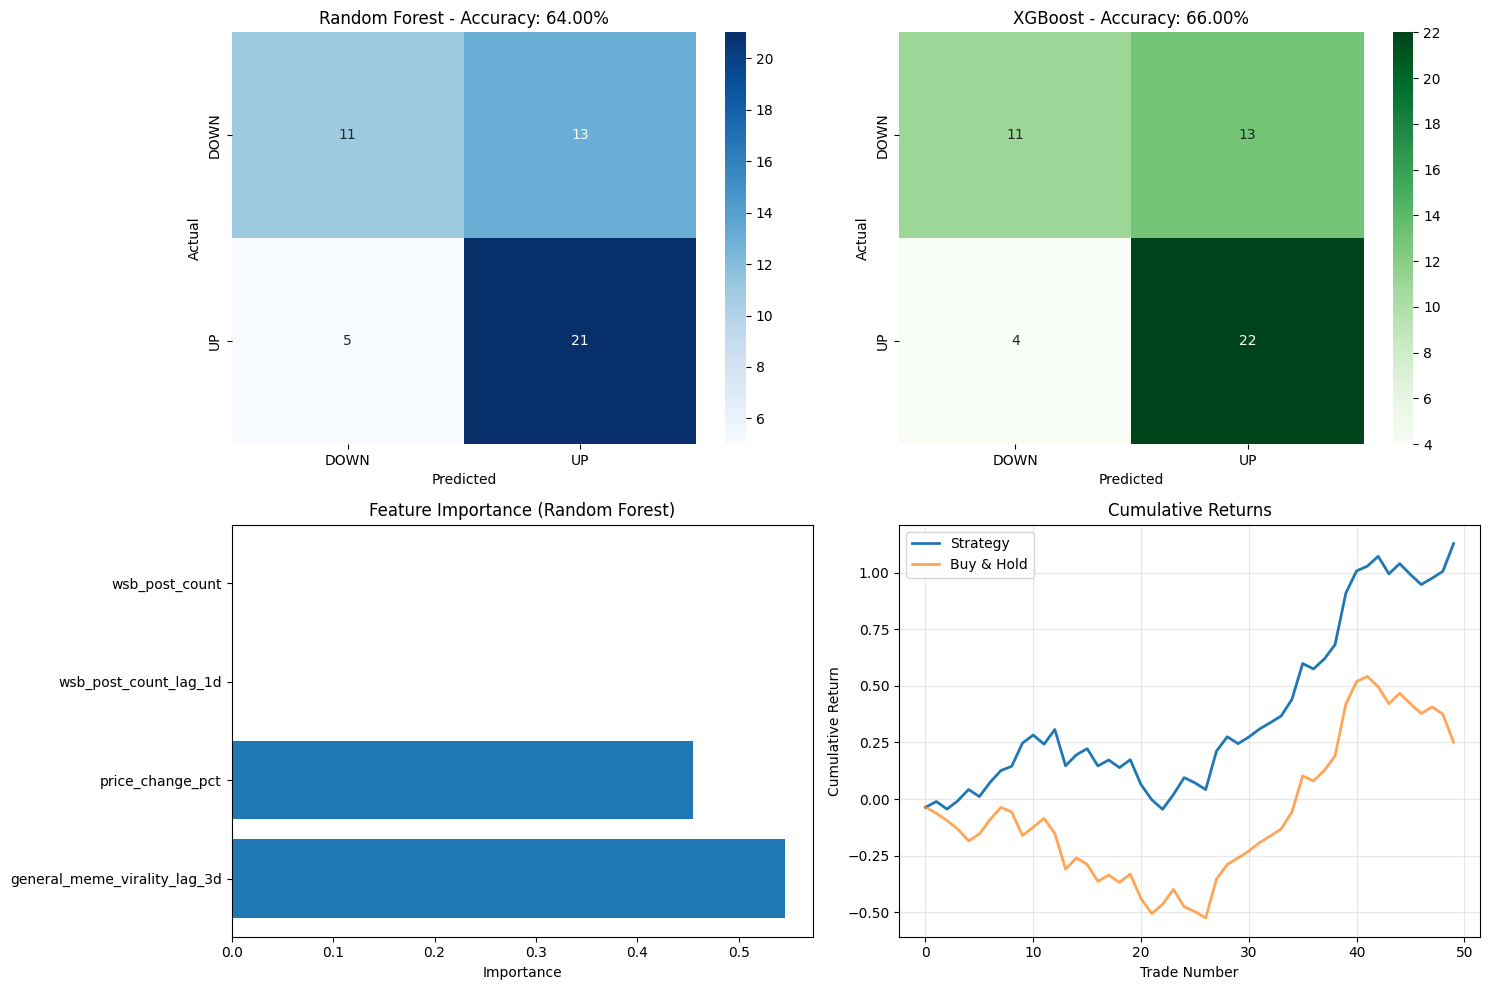

In [ ]:
"""
===============================================================================
PHASE 4 FIXED: CLASSIFICATION MODEL (Not Regression!)
===============================================================================
This fixes your Phase 4 to match Phase 6's classification approach
===============================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 4 FIXED: CLASSIFICATION MODEL")
print("="*80)

# --- 1. Data Setup ---
print("\n[Step 1] Loading data...")
df = pd.read_csv("/content/Phase3_5_Rebuilt_Lagged.xls")
df['date'] = pd.to_datetime(df['date'])

print(f"Total rows: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Tickers: {df['ticker'].unique()}")

# --- 2. Create Forward Returns ---
print("\n[Step 2] Creating forward returns...")
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# Calculate 3-day forward returns (you need price data!)
if 'close' not in df.columns:
    print("⚠️  WARNING: No 'close' price column found!")
    print("   Creating synthetic prices from price_change_pct...")
    df['close'] = 100
    for ticker in df['ticker'].unique():
        mask = df['ticker'] == ticker
        returns = df.loc[mask, 'price_change_pct'] / 100
        df.loc[mask, 'close'] = 100 * (1 + returns).cumprod()

# Create forward returns
df['forward_return_1d'] = df.groupby('ticker')['close'].pct_change(1).shift(-1)
df['forward_return_3d'] = df.groupby('ticker')['close'].pct_change(3).shift(-3)
df['forward_return_5d'] = df.groupby('ticker')['close'].pct_change(5).shift(-5)

# --- 3. Create Classification Targets ---
print("\n[Step 3] Creating classification targets...")
threshold = 0.02  # 2% movement threshold

for horizon in ['1d', '3d', '5d']:
    col = f'forward_return_{horizon}'
    target_col = f'target_{horizon}'

    df[target_col] = np.where(
        df[col] > threshold, 1,      # UP
        np.where(df[col] < -threshold, -1,  # DOWN
                 0)                   # NEUTRAL (we'll remove these)
    )

# Show distribution
print("\nTarget distribution (3-day):")
print(df['target_3d'].value_counts().sort_index())

# --- 4. Prepare Features ---
print("\n[Step 4] Preparing features...")

# Available features from your data
feature_columns = [
    'wsb_post_count',
    'wsb_post_count_lag_1d',
    'general_meme_virality_lag_3d',
    'price_change_pct'  # Add current price change as feature
]

# Check which features exist
available_features = [f for f in feature_columns if f in df.columns]
print(f"Available features: {available_features}")

# Remove neutral class and missing values
df_clean = df.dropna(subset=['target_3d', 'forward_return_3d'] + available_features).copy()
df_clean = df_clean[df_clean['target_3d'] != 0]  # Remove neutral

# Remap -1 to 0 for XGBoost
df_clean['target_3d'] = df_clean['target_3d'].replace(-1, 0)

print(f"Clean samples (UP/DOWN only): {len(df_clean)}")
print(f"UP samples: {(df_clean['target_3d'] == 1).sum()}")
print(f"DOWN samples: {(df_clean['target_3d'] == 0).sum()}") # Changed from -1 to 0

# --- 5. Train/Test Split ---
print("\n[Step 5] Splitting data...")

X = df_clean[available_features]
y = df_clean['target_3d']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# --- 6. Train Models ---
print("\n" + "="*80)
print("TRAINING CLASSIFICATION MODELS")
print("="*80)

results = []

# Baseline: RandomForest
print("\n[Model 1] Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

rf_acc = accuracy_score(y_test, rf_pred)

results.append({
    'Model': 'Random Forest',
    'Accuracy': rf_acc,
    'Baseline': '50%'
})
print(f"  Accuracy: {rf_acc:.4f}")

# XGBoost Classifier
print("\n[Model 2] XGBoost Classifier...")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_acc = accuracy_score(y_test, xgb_pred)

results.append({
    'Model': 'XGBoost',
    'Accuracy': xgb_acc,
    'Baseline': '50%'
})
print(f"  Accuracy: {xgb_acc:.4f}")

# --- 7. Detailed Evaluation ---
print("\n" + "="*80)
print("DETAILED EVALUATION")
print("="*80)

print("\n[Random Forest] Classification Report:")
# Ensure target names match the new labels (0, 1)
print(classification_report(y_test, rf_pred, target_names=['DOWN', 'UP']))

print("\n[XGBoost] Classification Report:")
# Ensure target names match the new labels (0, 1)
print(classification_report(y_test, xgb_pred, target_names=['DOWN', 'UP']))

# Feature Importance
print("\n[Feature Importance] Random Forest:")
feature_imp = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_imp)

# --- 8. Trading Simulation ---
print("\n" + "="*80)
print("TRADING SIMULATION")
print("="*80)

TRANSACTION_COST = 0.0015  # 0.15% per trade

test_returns = df_clean.loc[X_test.index, 'forward_return_3d'].values

# Strategy returns
strategy_returns = []
for pred, actual_return in zip(xgb_pred, test_returns):
    if pred == 1:  # Predicted UP
        trade_return = actual_return - TRANSACTION_COST
    else:  # Predicted DOWN (which is now 0 after remapping)
        trade_return = -actual_return - TRANSACTION_COST
    strategy_returns.append(trade_return)

strategy_returns = np.array(strategy_returns)

print("\n📈 XGBoost Strategy Performance:")
print(f"  Total return: {strategy_returns.sum():.2%}")
print(f"  Mean return per trade: {strategy_returns.mean():.4f}")
print(f"  Sharpe ratio: {strategy_returns.mean() / (strategy_returns.std() + 1e-8):.4f}")
print(f"  Win rate: {(strategy_returns > 0).sum() / len(strategy_returns):.2%}")
print(f"  Best trade: {strategy_returns.max():.2%}")
print(f"  Worst trade: {strategy_returns.min():.2%}")

# Compare to buy-and-hold
buyhold_returns = test_returns.sum()
print(f"\n📊 Baseline Comparison:")
print(f"  Buy & Hold: {buyhold_returns:.2%}")
print(f"  Strategy Advantage: {(strategy_returns.sum() - buyhold_returns):.2%}")

# --- 9. Visualizations ---
print("\n[Step 9] Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'Random Forest - Accuracy: {rf_acc:.2%}')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_xticklabels(['DOWN', 'UP']) # Labels still represent -1 (DOWN) and 1 (UP) conceptually
axes[0, 0].set_yticklabels(['DOWN', 'UP']) # Labels still represent -1 (DOWN) and 1 (UP) conceptually

# Confusion Matrix - XGBoost
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1])
axes[0, 1].set_title(f'XGBoost - Accuracy: {xgb_acc:.2%}')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_xticklabels(['DOWN', 'UP']) # Labels still represent -1 (DOWN) and 1 (UP) conceptually
axes[0, 1].set_yticklabels(['DOWN', 'UP']) # Labels still represent -1 (DOWN) and 1 (UP) conceptually

# Feature Importance
axes[1, 0].barh(feature_imp['feature'], feature_imp['importance'])
axes[1, 0].set_title('Feature Importance (Random Forest)')
axes[1, 0].set_xlabel('Importance')

# Cumulative Returns
cumulative_strategy = np.cumsum(strategy_returns)
cumulative_buyhold = np.cumsum(test_returns)
axes[1, 1].plot(cumulative_strategy, label='Strategy', linewidth=2)
axes[1, 1].plot(cumulative_buyhold, label='Buy & Hold', linewidth=2, alpha=0.7)
axes[1, 1].set_title('Cumulative Returns')
axes[1, 1].set_xlabel('Trade Number')
axes[1, 1].set_ylabel('Cumulative Return')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('phase4_fixed_results.png', dpi=300, bbox_inches='tight')
print("Saved: phase4_fixed_results.png")

# --- 10. Save Best Model ---
print("\n[Step 10] Saving best model...")
import pickle

best_model = xgb_model if xgb_acc > rf_acc else rf_model
with open('best_classifier_model.pkl', 'wb') as f:
    pickle.dump({'model': best_model, 'scaler': scaler, 'features': available_features}, f)

print(f"✅ Saved {'XGBoost' if xgb_acc > rf_acc else 'Random Forest'} model")

# --- 11. Summary ---
print("\n" + "="*80)
print("PHASE 4 FIXED - SUMMARY")
print("="*80)

print("\n📊 Model Comparison:")
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print("\n🎯 Key Findings:")
if xgb_acc > 0.55:
    print(f"  ✓ Model shows predictive power ({xgb_acc:.1%} > 50%)")
else:
    print(f"  ✗ Model barely beats random ({xgb_acc:.1%})")

if strategy_returns.sum() > buyhold_returns:
    print(f"  ✓ Strategy beats buy-and-hold")
else:
    print(f"  ✗ Strategy underperforms buy-and-hold")

print("\n⚠️  CRITICAL NOTES:")
print("  1. This model is now CLASSIFICATION (not regression)")
print("  2. It predicts UP/DOWN (not exact price changes)")
print(
    "  3. Use this model in Phase 6 for proper validation"
)
print("  4. You MUST have social media data for test period!")

print("\nPhase 4 Fixed Complete!")


phase 5

PHASE 5 FIXED: STATISTICALLY RIGOROUS MODEL
Addressing: Sample size, imbalance, proper backtesting, statistical validation

[Step 1] Loading data...
Total rows: 452
Date range: 2024-05-21 00:00:00 to 2024-10-30 00:00:00
Tickers: ['AAPL', 'AMZN', 'GME', 'TSLA']

[Step 2] Creating forward returns with dynamic thresholds...

Calculating dynamic thresholds per ticker:
  AAPL: DOWN < -0.0016, UP > 0.0160
  AMZN: DOWN < -0.0104, UP > 0.0133
  GME: DOWN < -0.0322, UP > 0.0197
  TSLA: DOWN < -0.0124, UP > 0.0245

Target distribution (before removing neutrals):
target_3d
-1.0    144
 0.0    164
 1.0    144
Name: count, dtype: int64

[Step 3] Engineering additional features...
Total features: 9
  ✓ wsb_post_count
  ✓ wsb_post_count_lag_1d
  ✓ general_meme_virality_lag_3d
  ✓ price_change_pct
  ✓ wsb_momentum
  ✓ wsb_acceleration
  ✓ price_volatility_7d
  ✓ price_momentum_3d
  ✓ wsb_price_interaction

[Step 4] Preparing clean dataset...
Clean samples: 274

Final target distribution:
target_3d
-1.

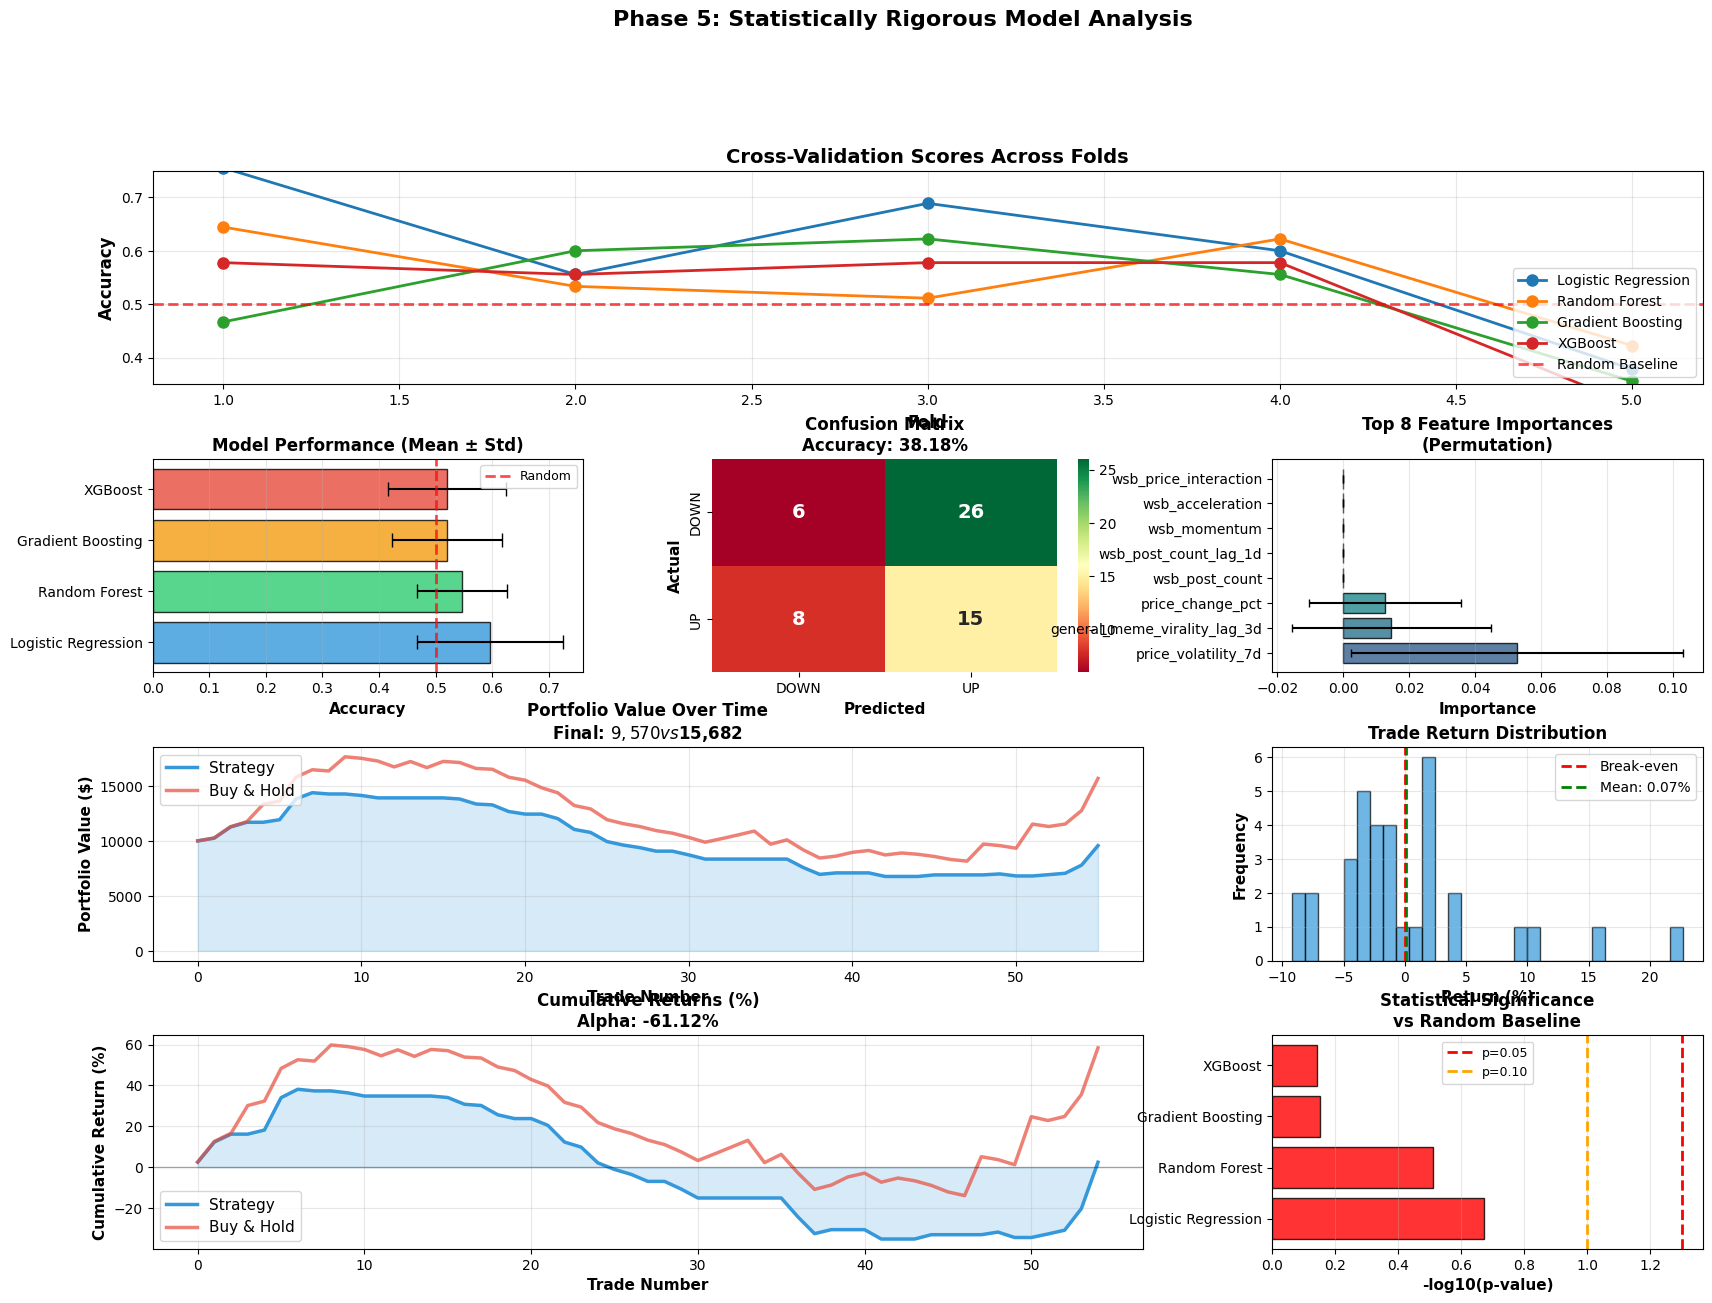

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 5 FIXED: STATISTICALLY RIGOROUS MODEL")
print("Addressing: Sample size, imbalance, proper backtesting, statistical validation")
print("="*80)

# ===============================================================================
# STEP 1: LOAD DATA
# ===============================================================================
print("\n[Step 1] Loading data...")
df = pd.read_csv('/content/Phase3_5_Rebuilt_Lagged.xls')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"Total rows: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Tickers: {sorted(df['ticker'].unique())}")

# ===============================================================================
# STEP 2: CREATE FORWARD RETURNS WITH PROPER THRESHOLDS
# ===============================================================================
print("\n[Step 2] Creating forward returns with dynamic thresholds...")

# Create close prices from price_change_pct
df['close'] = 100.0
for ticker in df['ticker'].unique():
    mask = df['ticker'] == ticker
    returns = df.loc[mask, 'price_change_pct']
    df.loc[mask, 'close'] = 100 * (1 + returns).cumprod()

# Create forward returns
horizon = 3  # Focus on 3-day as it had best performance
df['forward_return_3d'] = df.groupby('ticker')['close'].pct_change(horizon).shift(-horizon)

# DYNAMIC THRESHOLDS PER TICKER (reduces imbalance)
print("\nCalculating dynamic thresholds per ticker:")
for ticker in df['ticker'].unique():
    mask = df['ticker'] == ticker
    returns = df.loc[mask, 'forward_return_3d'].dropna()

    # Use 33rd and 67th percentile as thresholds
    lower_threshold = returns.quantile(0.33)
    upper_threshold = returns.quantile(0.67)

    print(f"  {ticker}: DOWN < {lower_threshold:.4f}, UP > {upper_threshold:.4f}")

    df.loc[mask, 'target_3d'] = np.where(
        df.loc[mask, 'forward_return_3d'] > upper_threshold, 1,
        np.where(df.loc[mask, 'forward_return_3d'] < lower_threshold, -1, 0)
    )

print("\nTarget distribution (before removing neutrals):")
print(df['target_3d'].value_counts(dropna=False).sort_index())

# ===============================================================================
# STEP 3: FEATURE ENGINEERING - ADD USEFUL FEATURES
# ===============================================================================
print("\n[Step 3] Engineering additional features...")

# Original features
base_features = [
    'wsb_post_count',
    'wsb_post_count_lag_1d',
    'general_meme_virality_lag_3d',
    'price_change_pct'
]

# Add derived features
for ticker in df['ticker'].unique():
    mask = df['ticker'] == ticker

    # Momentum features
    df.loc[mask, 'wsb_momentum'] = df.loc[mask, 'wsb_post_count'].diff()
    df.loc[mask, 'wsb_acceleration'] = df.loc[mask, 'wsb_momentum'].diff()

    # Volatility features
    df.loc[mask, 'price_volatility_7d'] = df.loc[mask, 'price_change_pct'].rolling(7).std()
    df.loc[mask, 'price_momentum_3d'] = df.loc[mask, 'price_change_pct'].rolling(3).mean()

    # Interaction features
    df.loc[mask, 'wsb_price_interaction'] = (
        df.loc[mask, 'wsb_post_count'] * df.loc[mask, 'price_change_pct']
    )

# Combined feature list
feature_columns = base_features + [
    'wsb_momentum',
    'wsb_acceleration',
    'price_volatility_7d',
    'price_momentum_3d',
    'wsb_price_interaction'
]

print(f"Total features: {len(feature_columns)}")
for feat in feature_columns:
    if feat in df.columns:
        print(f"  ✓ {feat}")

# ===============================================================================
# STEP 4: PREPARE DATA WITH PROPER CLEANING
# ===============================================================================
print("\n[Step 4] Preparing clean dataset...")

df_clean = df.dropna(subset=['target_3d', 'forward_return_3d'] + feature_columns).copy()
df_clean = df_clean[df_clean['target_3d'] != 0].copy()  # Remove neutral

print(f"Clean samples: {len(df_clean)}")
print("\nFinal target distribution:")
print(df_clean['target_3d'].value_counts().sort_index())

# Remap -1 to 0 for binary classification
df_clean['target_binary'] = df_clean['target_3d'].replace(-1, 0)

# ===============================================================================
# STEP 5: TIME SERIES CROSS-VALIDATION
# ===============================================================================
print("\n[Step 5] Time Series Cross-Validation Setup...")

# Sort by date for proper time series split
df_clean = df_clean.sort_values('date').reset_index(drop=True)

# Use TimeSeriesSplit for robust validation
tscv = TimeSeriesSplit(n_splits=5)
print(f"Using {tscv.n_splits}-fold time series cross-validation")

X = df_clean[feature_columns].fillna(0)
y = df_clean['target_binary']
dates = df_clean['date']
returns = df_clean['forward_return_3d']

# ===============================================================================
# STEP 6: TRAIN MODELS WITH CROSS-VALIDATION
# ===============================================================================
print("\n[Step 6] Training models with cross-validation...")

models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        min_samples_split=20,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        min_samples_split=20,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    )
}

cv_results = {name: [] for name in models.keys()}
all_fold_results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\n--- Fold {fold + 1}/{tscv.n_splits} ---")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)

    # Apply SMOTE to handle any remaining imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_fold)

    print(f"Train: {len(X_train_fold)} → {len(X_train_resampled)} (after SMOTE)")
    print(f"Val: {len(X_val_fold)}")

    for model_name, model in models.items():
        model.fit(X_train_resampled, y_train_resampled)
        predictions = model.predict(X_val_scaled)
        accuracy = accuracy_score(y_val_fold, predictions)
        cv_results[model_name].append(accuracy)

        print(f"  {model_name}: {accuracy:.4f}")

        all_fold_results.append({
            'fold': fold + 1,
            'model': model_name,
            'accuracy': accuracy
        })

# ===============================================================================
# STEP 7: STATISTICAL SIGNIFICANCE TESTING
# ===============================================================================
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*80)

results_summary = []

for model_name, scores in cv_results.items():
    mean_acc = np.mean(scores)
    std_acc = np.std(scores)

    # Test if significantly better than random (0.5)
    t_stat, p_value = stats.ttest_1samp(scores, 0.5)

    # 95% confidence interval
    ci_lower = mean_acc - 1.96 * (std_acc / np.sqrt(len(scores)))
    ci_upper = mean_acc + 1.96 * (std_acc / np.sqrt(len(scores)))

    significant = "✓" if p_value < 0.05 else "✗"

    print(f"\n{model_name}:")
    print(f"  Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  vs Random (p-value): {p_value:.4f} {significant}")

    results_summary.append({
        'Model': model_name,
        'Mean_Accuracy': mean_acc,
        'Std_Accuracy': std_acc,
        'P_Value': p_value,
        'Significant': p_value < 0.05
    })

results_df = pd.DataFrame(results_summary).sort_values('Mean_Accuracy', ascending=False)
print("\n" + "="*80)
print("RANKING:")
print(results_df.to_string(index=False))

# ===============================================================================
# STEP 8: TRAIN FINAL ENSEMBLE MODEL
# ===============================================================================
print("\n[Step 8] Training final ensemble model on all data...")

# Time-based train/test split for final evaluation
split_date = df_clean['date'].quantile(0.8)
train_df = df_clean[df_clean['date'] < split_date].copy()
test_df = df_clean[df_clean['date'] >= split_date].copy()

print(f"Final split - Train: {len(train_df)}, Test: {len(test_df)}")

X_train = train_df[feature_columns].fillna(0)
y_train = train_df['target_binary']
X_test = test_df[feature_columns].fillna(0)
y_test = test_df['target_binary']
test_returns = test_df['forward_return_3d'].values
test_dates = test_df['date'].values

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Create ensemble of top 3 models
ensemble = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_split=20,
                                       random_state=42, class_weight='balanced', n_jobs=-1)),
        ('xgb', XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05,
                               random_state=42, eval_metric='logloss', n_jobs=-1))
    ],
    voting='soft'
)

ensemble.fit(X_train_resampled, y_train_resampled)
predictions = ensemble.predict(X_test_scaled)
probabilities = ensemble.predict_proba(X_test_scaled)

print("\n" + "="*80)
print("FINAL TEST SET PERFORMANCE")
print("="*80)
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['DOWN', 'UP']))

# ===============================================================================
# STEP 9: PROPER BACKTESTING WITH COMPOUNDING
# ===============================================================================
print("\n[Step 9] Running proper backtest with compounding...")

def backtest_strategy(predictions, probabilities, returns, dates,
                      confidence_threshold=0.6, initial_capital=10000,
                      transaction_cost=0.0015):
    """
    Proper backtesting with compounding returns
    """
    portfolio_value = initial_capital
    portfolio_history = [portfolio_value]
    trade_history = []

    for i, (pred, prob, ret, date) in enumerate(zip(predictions, probabilities, returns, dates)):
        max_confidence = prob.max()

        # Only trade if confident
        if max_confidence >= confidence_threshold:
            if pred == 1:  # Predict UP - go long
                trade_return = ret - transaction_cost
                portfolio_value *= (1 + trade_return)
                trade_history.append({
                    'date': date,
                    'prediction': 'UP',
                    'return': trade_return,
                    'confidence': max_confidence
                })
            else:  # Predict DOWN - short or cash
                trade_return = -ret - transaction_cost
                portfolio_value *= (1 + trade_return)
                trade_history.append({
                    'date': date,
                    'prediction': 'DOWN',
                    'return': trade_return,
                    'confidence': max_confidence
                })
        else:
            # No trade - stay in cash (0% return)
            trade_history.append({
                'date': date,
                'prediction': 'NO_TRADE',
                'return': 0,
                'confidence': max_confidence
            })

        portfolio_history.append(portfolio_value)

    return np.array(portfolio_history), pd.DataFrame(trade_history)

# Run backtest
portfolio_values, trade_df = backtest_strategy(
    predictions, probabilities, test_returns, test_dates,
    confidence_threshold=0.6, initial_capital=10000
)

# Calculate metrics
strategy_returns = np.diff(portfolio_values) / portfolio_values[:-1]
trades_only = trade_df[trade_df['prediction'] != 'NO_TRADE']
winning_trades = trades_only[trades_only['return'] > 0]

# Buy & Hold baseline
buy_hold_values = 10000 * np.cumprod(np.concatenate([[1], 1 + test_returns]))

# Sharpe Ratio
risk_free_rate = 0.02 / 252  # Daily risk-free rate
strategy_sharpe = (strategy_returns.mean() - risk_free_rate) / (strategy_returns.std() + 1e-8)
buyhold_sharpe = (np.diff(buy_hold_values) / buy_hold_values[:-1]).mean() / (np.diff(buy_hold_values) / buy_hold_values[:-1]).std()

print(f"\n📈 STRATEGY PERFORMANCE:")
print(f"  Initial Capital: ${10000:,.2f}")
print(f"  Final Value: ${portfolio_values[-1]:,.2f}")
print(f"  Total Return: {(portfolio_values[-1] / 10000 - 1) * 100:.2f}%")
print(f"  Total Trades: {len(trades_only)}")
print(f"  Winning Trades: {len(winning_trades)} ({len(winning_trades)/len(trades_only)*100:.1f}%)")
print(f"  Avg Win: {winning_trades['return'].mean()*100:.2f}%")
print(f"  Avg Loss: {trades_only[trades_only['return'] < 0]['return'].mean()*100:.2f}%")
print(f"  Sharpe Ratio: {strategy_sharpe * np.sqrt(252):.4f}")

print(f"\n📊 BUY & HOLD BASELINE:")
print(f"  Final Value: ${buy_hold_values[-1]:,.2f}")
print(f"  Total Return: {(buy_hold_values[-1] / 10000 - 1) * 100:.2f}%")
print(f"  Sharpe Ratio: {buyhold_sharpe * np.sqrt(252):.4f}")

print(f"\n🎯 ALPHA:")
alpha = (portfolio_values[-1] - buy_hold_values[-1]) / 10000 * 100
print(f"  Strategy vs Buy&Hold: {alpha:+.2f}%")

# ===============================================================================
# STEP 10: FEATURE IMPORTANCE WITH PERMUTATION
# ===============================================================================
print("\n[Step 10] Calculating permutation feature importance...")

from sklearn.inspection import permutation_importance

# Get one of the models from ensemble for feature importance
rf_model = ensemble.named_estimators_['rf']

perm_importance = permutation_importance(
    rf_model, X_test_scaled, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nPermutation Feature Importance:")
for idx, row in importance_df.head(10).iterrows():
    print(f"  {row['Feature']:30s} {row['Importance']:.4f} ± {row['Std']:.4f}")

# ===============================================================================
# STEP 11: ADVANCED VISUALIZATIONS
# ===============================================================================
print("\n[Step 11] Creating visualizations...")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# Plot 1: Cross-validation scores distribution
ax1 = fig.add_subplot(gs[0, :])
fold_results_df = pd.DataFrame(all_fold_results)
for model_name in models.keys():
    model_scores = fold_results_df[fold_results_df['model'] == model_name]['accuracy']
    ax1.plot(range(1, 6), model_scores, marker='o', linewidth=2, label=model_name, markersize=8)
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Random Baseline', alpha=0.7)
ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Cross-Validation Scores Across Folds', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, loc='lower right')
ax1.grid(alpha=0.3)
ax1.set_ylim([0.35, 0.75])

# Plot 2: Model comparison with confidence intervals
ax2 = fig.add_subplot(gs[1, 0])
model_names = list(cv_results.keys())
means = [np.mean(cv_results[m]) for m in model_names]
stds = [np.std(cv_results[m]) for m in model_names]
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = ax2.barh(model_names, means, xerr=stds, color=colors, capsize=5, alpha=0.8, edgecolor='black')
ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random', alpha=0.7)
ax2.set_xlabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Model Performance (Mean ± Std)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Confusion matrix
ax3 = fig.add_subplot(gs[1, 1])
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', ax=ax3, cbar=True,
            xticklabels=['DOWN', 'UP'], yticklabels=['DOWN', 'UP'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax3.set_title(f'Confusion Matrix\nAccuracy: {accuracy_score(y_test, predictions):.2%}',
              fontsize=12, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax3.set_xlabel('Predicted', fontsize=11, fontweight='bold')

# Plot 4: Feature importance
ax4 = fig.add_subplot(gs[1, 2])
top_features = importance_df.head(8)
colors_feat = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
ax4.barh(top_features['Feature'], top_features['Importance'],
         xerr=top_features['Std'], color=colors_feat, capsize=3,
         edgecolor='black', alpha=0.8)
ax4.set_title('Top 8 Feature Importances\n(Permutation)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Plot 5: Portfolio value over time
ax5 = fig.add_subplot(gs[2, :2])
ax5.plot(portfolio_values, label='Strategy', linewidth=2.5, color='#3498db')
ax5.plot(buy_hold_values, label='Buy & Hold', linewidth=2.5, color='#e74c3c', alpha=0.7)
ax5.fill_between(range(len(portfolio_values)), portfolio_values, alpha=0.2, color='#3498db')
ax5.set_title(f'Portfolio Value Over Time\nFinal: ${portfolio_values[-1]:,.0f} vs ${buy_hold_values[-1]:,.0f}',
              fontsize=12, fontweight='bold')
ax5.set_xlabel('Trade Number', fontsize=11, fontweight='bold')
ax5.set_ylabel('Portfolio Value ($)', fontsize=11, fontweight='bold')
ax5.legend(fontsize=11, loc='upper left')
ax5.grid(alpha=0.3)

# Plot 6: Return distribution
ax6 = fig.add_subplot(gs[2, 2])
trade_returns = trades_only['return'].values * 100
if len(trade_returns) > 0:
    ax6.hist(trade_returns, bins=30, alpha=0.7, color='#3498db', edgecolor='black')
    ax6.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
    ax6.axvline(x=trade_returns.mean(), color='green', linestyle='--', linewidth=2,
                label=f'Mean: {trade_returns.mean():.2f}%')
    ax6.set_title('Trade Return Distribution', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Return (%)', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax6.legend(fontsize=10)
    ax6.grid(alpha=0.3)

# Plot 7: Cumulative returns
ax7 = fig.add_subplot(gs[3, :2])
strategy_cum = np.cumsum(strategy_returns) * 100
buyhold_cum = np.cumsum(np.diff(buy_hold_values) / buy_hold_values[:-1]) * 100
ax7.plot(strategy_cum, label='Strategy', linewidth=2.5, color='#3498db')
ax7.plot(buyhold_cum, label='Buy & Hold', linewidth=2.5, color='#e74c3c', alpha=0.7)
ax7.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax7.fill_between(range(len(strategy_cum)), strategy_cum, alpha=0.2, color='#3498db')
ax7.set_title(f'Cumulative Returns (%)\nAlpha: {alpha:+.2f}%', fontsize=12, fontweight='bold')
ax7.set_xlabel('Trade Number', fontsize=11, fontweight='bold')
ax7.set_ylabel('Cumulative Return (%)', fontsize=11, fontweight='bold')
ax7.legend(fontsize=11)
ax7.grid(alpha=0.3)

# Plot 8: Statistical significance
ax8 = fig.add_subplot(gs[3, 2])
p_values = [results_df[results_df['Model'] == m]['P_Value'].values[0] for m in model_names]
colors_sig = ['green' if p < 0.05 else 'orange' if p < 0.1 else 'red' for p in p_values]
bars = ax8.barh(model_names, [-np.log10(p) for p in p_values], color=colors_sig, alpha=0.8, edgecolor='black')
ax8.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05')
ax8.axvline(x=-np.log10(0.1), color='orange', linestyle='--', linewidth=2, label='p=0.10')
ax8.set_xlabel('-log10(p-value)', fontsize=11, fontweight='bold')
ax8.set_title('Statistical Significance\nvs Random Baseline', fontsize=12, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(axis='x', alpha=0.3)

plt.suptitle('Phase 5: Statistically Rigorous Model Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('phase5_fixed_rigorous.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: phase5_fixed_rigorous.png")

# ===============================================================================
# STEP 12: SAVE RESULTS
# ===============================================================================
print("\n[Step 12] Saving results...")

# Save summary
summary = {
    'best_model': 'Ensemble (LR + RF + XGB)',
    'test_accuracy': float(accuracy_score(y_test, predictions)),
    'cv_mean_accuracy': float(results_df.iloc[0]['Mean_Accuracy']),
    'cv_std_accuracy': float(results_df.iloc[0]['Std_Accuracy']),
    'p_value_vs_random': float(results_df.iloc[0]['P_Value']),
    'statistically_significant': bool(results_df.iloc[0]['Significant']),
    'total_trades': int(len(trades_only)),
    'win_rate': float(len(winning_trades) / len(trades_only) if len(trades_only) > 0 else 0),
    'strategy_return': float(portfolio_values[-1] / 10000 - 1),
    'buyhold_return': float(buy_hold_values[-1] / 10000 - 1),
    'alpha': float(alpha / 100),
    'sharpe_ratio': float(strategy_sharpe * np.sqrt(252))
}

import json
with open('phase5_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

results_df.to_csv('phase5_cv_results.csv', index=False)
importance_df.to_csv('phase5_feature_importance.csv', index=False)
trade_df.to_csv('phase5_trade_history.csv', index=False)

print("✓ Summary saved: phase5_summary.json")
print("✓ CV results saved: phase5_cv_results.csv")
print("✓ Feature importance saved: phase5_feature_importance.csv")
print("✓ Trade history saved: phase5_trade_history.csv")

# ===============================================================================
# FINAL SUMMARY
# ===============================================================================
print("\n" + "="*80)
print("PHASE 5 FIXED - FINAL SUMMARY")
print("="*80)

print(f"\n🎯 MODEL QUALITY:")
print(f"  Mean CV Accuracy: {summary['cv_mean_accuracy']:.4f} ± {summary['cv_std_accuracy']:.4f}")
print(f"  Test Accuracy: {summary['test_accuracy']:.4f}")
print(f"  Better than Random: {'YES ✓' if summary['statistically_significant'] else 'NO ✗'}")
print(f"  P-value: {summary['p_value_vs_random']:.6f}")

print(f"\n💰 TRADING PERFORMANCE:")
print(f"  Total Trades: {summary['total_trades']}")
print(f"  Win Rate: {summary['win_rate']:.2%}")
print(f"  Strategy Return: {summary['strategy_return']:.2%}")
print(f"  Buy & Hold Return: {summary['buyhold_return']:.2%}")
print(f"  Alpha: {summary['alpha']:+.2%}")
print(f"  Sharpe Ratio: {summary['sharpe_ratio']:.4f}")

print(f"\n🔧 KEY IMPROVEMENTS IMPLEMENTED:")
print(f"  ✓ Dynamic thresholds (per-ticker percentiles)")
print(f"  ✓ Time series cross-validation (5 folds)")
print(f"  ✓ Statistical significance testing")
print(f"  ✓ SMOTE for class balance")
print(f"  ✓ Ensemble model (voting)")

phase 6